In [1]:
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SKPipeline

from sklearn.svm import SVC
from itertools import combinations

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,  make_scorer, fbeta_score, roc_curve, roc_auc_score, f1_score
from scipy.stats import mode

from sklearn.ensemble import RandomForestClassifier
from collections import Counter



In [2]:
stroke = pd.read_csv("../00-data/healthcare-dataset-stroke-data.csv")

stroke


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
X = stroke.drop(['stroke', 'id'], axis=1)

y = stroke['stroke'].values

Creo una prima pipeline per fare imputer, scaler, undersampling e oversampling in modo da rendere i dati buoni per studi e modelli

In [4]:
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

numerical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='mean')),
  ('scaler', StandardScaler())
])

categorical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_with_imputation = ColumnTransformer(
  transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
  ])

pipeline_preprocessing = SKPipeline(steps=[
  ('preprocessor', preprocessor_with_imputation),
])

pipeline_sampling = ImbPipeline([
  ('preprocessor', preprocessor_with_imputation),
  ('undersampler', RandomUnderSampler(random_state=0, sampling_strategy=0.20)),
  ('oversampler', ADASYN(n_neighbors=7, random_state=0, sampling_strategy=1)),
])

In [5]:
# pipeline_model = SKPipeline([
#   ('pca', PCA(random_state=0, n_components=None)),
#   # ('classifier', SVC(random_state=0, probability=True, kernel='rbf', class_weight='balanced'))
# ])

ovviamente eseguo il train test split per il futuro

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

uso la pipeline per avere dati buoni per la pca

In [7]:
X_resampled, y_resampled = pipeline_sampling.fit_resample(X_train, y_train)

In questo momento devo esplorare i risultati, quindi evito la pipeline e mi concentro sul vedere quanto spiegano le varie componenti

In [8]:
pca = PCA(random_state=0, n_components=None)
X_train_pca = pca.fit(X_resampled)
variance_ratio = X_train_pca.explained_variance_ratio_

variance_ratio

array([2.80922738e-01, 1.77370287e-01, 1.26938553e-01, 9.99938888e-02,
       6.51169567e-02, 5.43778094e-02, 5.18458345e-02, 3.50230359e-02,
       3.18532059e-02, 2.20799378e-02, 2.01094422e-02, 1.60998926e-02,
       1.39202594e-02, 4.11640515e-03, 1.44844767e-04, 8.69099696e-05,
       4.07656176e-17, 1.91672579e-17, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

uso la funzione cumsum di numpy per vedere quanto spiegano le componenti principali man mano che si accumulano

In [9]:
variance_ratio_cumulative = np.cumsum(variance_ratio)

variance_ratio_cumulative

array([0.28092274, 0.45829302, 0.58523158, 0.68522547, 0.75034242,
       0.80472023, 0.85656607, 0.8915891 , 0.92344231, 0.94552225,
       0.96563169, 0.98173158, 0.99565184, 0.99976825, 0.99991309,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

considerando le prime 12 componenti principali riusciamo a spiegare il 96% della varianza, potrebbe essere interessante questo dato considerando che mi permette di quasi dimezzare il numero di dimensioni.

Ora vado a vedere un grafico cumulativo delle dimensioni

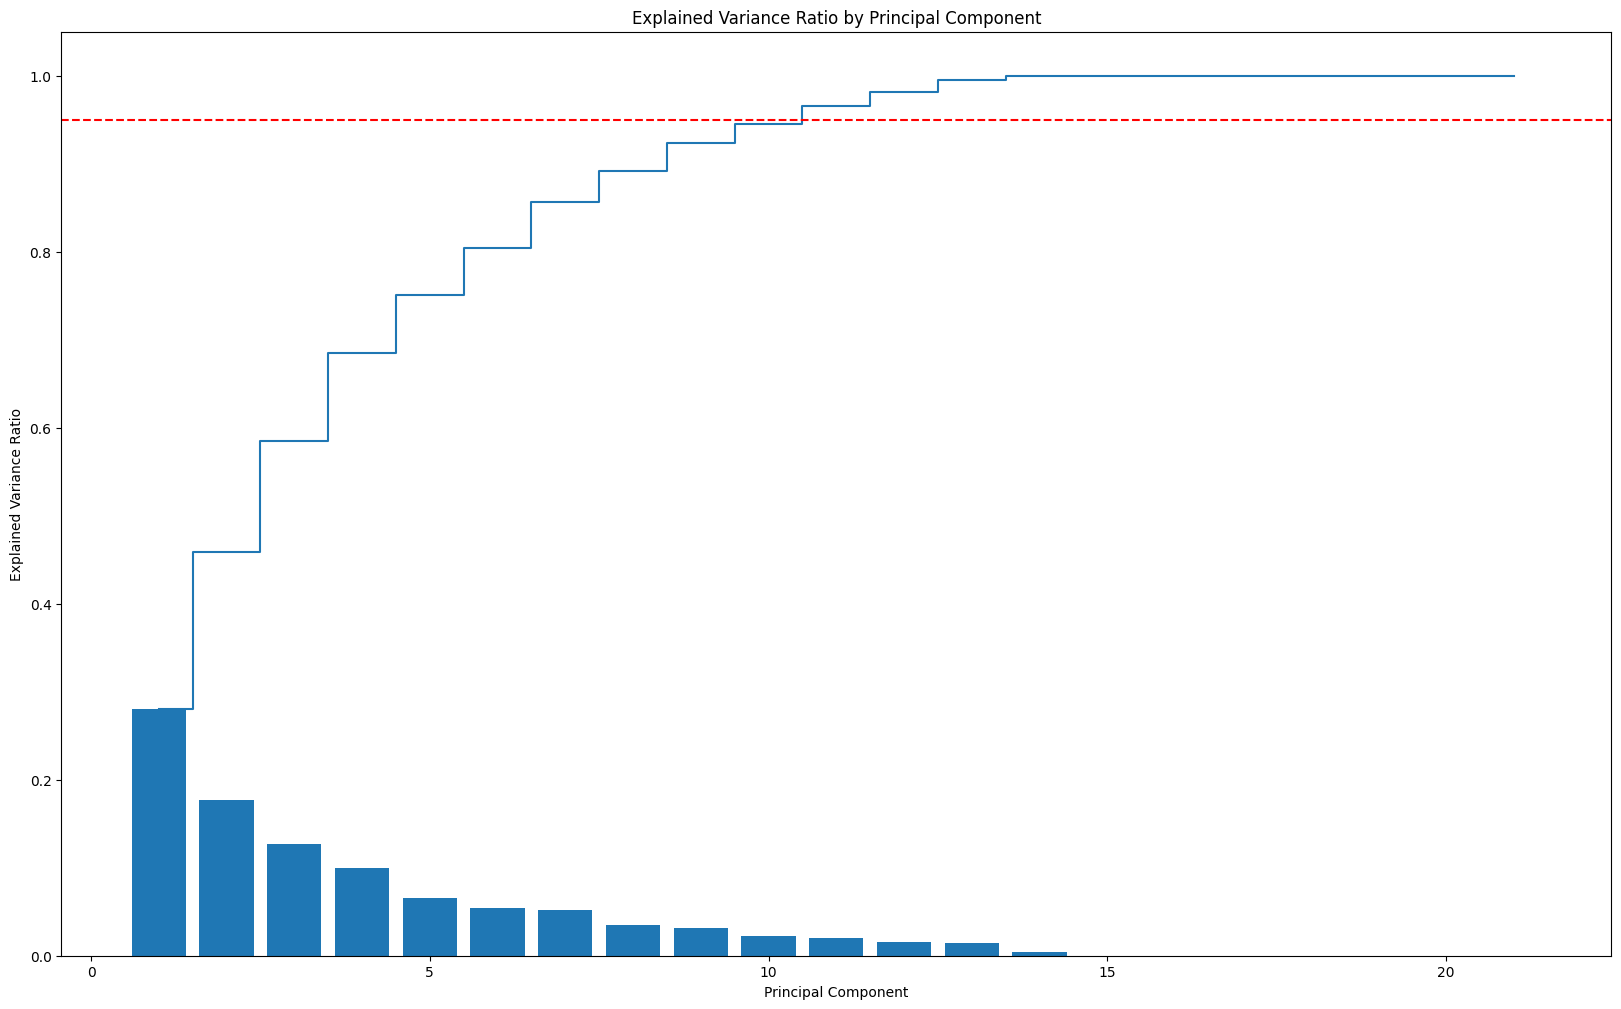

In [10]:
plt.figure(figsize=(20, 12))
plt.step(range(1, len(variance_ratio_cumulative) + 1), variance_ratio_cumulative, where='mid', label='Cumulative Explained Variance')
plt.bar(range(1, len(variance_ratio) + 1), variance_ratio, label='Explained Variance by Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.show()

vedo che con 11 dimensioni viene spiegato più del 95% della varianza.

La mia idea sarà addestrare un modello con le 2 dimensioni principali, poi quello con le 3, poi con le 4, 5 e così via fino ad 11 dimensioni.

Sottoporre i dati a un hard voting e considerare a 1 se il 30% dei voti risulta a 1

trasformo i dati

In [11]:
X_train_pca = pca.transform(X_resampled)


In [12]:
def balanced_score(y_true, y_pred, w_tp=0.6, w_tn=0.4):
    cm = confusion_matrix(y_true, y_pred)

    # cm layout:
    # [[TN, FP],
    #  [FN, TP]]
    tn, fp, fn, tp = cm.ravel()

    total_pos = tp + fn
    total_neg = tn + fp

    tpr = tp / total_pos if total_pos > 0 else 0  # Sensibilità / Recall
    tnr = tn / total_neg if total_neg > 0 else 0  # Specificità

    score = w_tp * tpr + w_tn * tnr
    return score

In [13]:
# from sklearn.model_selection import cross_val_score

def find_best_combination(X_train_pca, y_resampled, X_cv_test, y_cv_test, n_components):
    class ColumnSelector(BaseEstimator, TransformerMixin):
        def __init__(self, columns):
            self.columns = columns
        def fit(self, X, y=None):
            return self
        def transform(self, X):
            return X[:, self.columns]

    # Supponiamo di voler provare combinazioni di 2 componenti
    combs = list(combinations(range(11), n_components))

    best_score = 0
    best_model = None
    best_combination = None

    for comb in combs:
        # print(comb)
        pipeline = SKPipeline([
            ('selector', ColumnSelector(comb)),
            ('svm', SVC(kernel='linear', random_state=0))
            # class_weight='balanced'
        ])
        pipeline.fit(X_train_pca, y_resampled)
        preds = pipeline.predict(X_cv_test)
        # custom_scorer = make_scorer(balanced_score, greater_is_better=True)
        score = balanced_score(y_cv_test, preds, 0.6, 0.4)
        if score > best_score:
            best_score = score
            best_model = pipeline
            best_combination = comb

    return best_combination, best_score, best_model

In [14]:
models = []


for i in range(2, 12):
  X_secondary_split_train, X_secondary_split_test, y_secondary_split_train, y_secondary_split_test = train_test_split(X_train_pca, y_resampled, test_size=0.3, random_state=i)
  print(f"Testing combinations of {i} components")
  models.append(find_best_combination(X_secondary_split_train, y_secondary_split_train, X_secondary_split_test, y_secondary_split_test, i))

Testing combinations of 2 components
Testing combinations of 3 components
Testing combinations of 4 components
Testing combinations of 5 components
Testing combinations of 6 components
Testing combinations of 7 components
Testing combinations of 8 components
Testing combinations of 9 components
Testing combinations of 10 components
Testing combinations of 11 components


In [15]:
models

[((0, 3),
  np.float64(0.7431984648866217),
  Pipeline(steps=[('selector', ColumnSelector(columns=(0, 3))),
                  ('svm', SVC(kernel='linear', random_state=0))])),
 ((0, 3, 8),
  np.float64(0.7646360278647902),
  Pipeline(steps=[('selector', ColumnSelector(columns=(0, 3, 8))),
                  ('svm', SVC(kernel='linear', random_state=0))])),
 ((0, 2, 3, 9),
  np.float64(0.7763757981149286),
  Pipeline(steps=[('selector', ColumnSelector(columns=(0, 2, 3, 9))),
                  ('svm', SVC(kernel='linear', random_state=0))])),
 ((0, 1, 3, 9, 10),
  np.float64(0.7683080808080807),
  Pipeline(steps=[('selector', ColumnSelector(columns=(0, 1, 3, 9, 10))),
                  ('svm', SVC(kernel='linear', random_state=0))])),
 ((0, 1, 2, 3, 7, 9),
  np.float64(0.787777439951353),
  Pipeline(steps=[('selector', ColumnSelector(columns=(0, 1, 2, 3, 7, 9))),
                  ('svm', SVC(kernel='linear', random_state=0))])),
 ((0, 1, 2, 3, 4, 6, 7),
  np.float64(0.7904561403508772),


In [16]:
def hard_voting_predict(models, X_pca):
    all_preds = []

    for comb, score, pipeline in models:
        # print(comb)
        # print(X_pca)
        # print(X_pca[:, comb])
        preds = pipeline.predict(X_pca)
        all_preds.append(preds)

    all_preds = np.array(all_preds)

    final_preds = []
    for i in range(all_preds.shape[1]):
        votes = Counter(all_preds[:, i])
        pred = votes.most_common(1)[0][0]
        final_preds.append(pred)

    return np.array(final_preds)




In [17]:
X_train_pca

array([[-6.25945506e-01, -2.03784656e-02,  1.70147821e-01, ...,
        -4.16333634e-16,  1.94289029e-16,  8.88178420e-16],
       [ 6.84607466e-01,  2.53832181e+00, -1.08779112e+00, ...,
         1.88737914e-15,  4.99600361e-16, -5.88418203e-15],
       [-1.19003614e+00, -6.32125048e-01, -2.76265889e-01, ...,
         2.49800181e-16,  1.94289029e-16, -1.44328993e-15],
       ...,
       [-6.87642622e-01,  2.84484807e-02, -2.01218150e-01, ...,
        -3.60822483e-16, -4.44089210e-16,  9.99200722e-16],
       [-6.48988125e-01,  5.79223399e-02, -7.90008241e-03, ...,
        -3.05311332e-16, -1.02695630e-15,  1.88737914e-15],
       [-3.91343803e-01,  1.68223866e-01,  3.59646169e-01, ...,
        -4.16333634e-16, -5.55111512e-16,  1.44328993e-15]],
      shape=(1948, 21))

In [18]:
# X_resampled, y_resampled
final_preds = hard_voting_predict(models, X_train_pca)

In [19]:
def evaluate_predictions(predictions, y_true):
    # majority_vote = (np.stack(predictions).mean(axis=0) >= 0.2).astype(int)
    cm = confusion_matrix(y_true, predictions)
    class_names = ['Classe 0 (Nessun ictus)', 'Classe 1 (Ictus)']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d')
    plt.show()
    
    perc_true_negative = cm[0,0]*100/(cm[0,0]+cm[0,1])
    perc_true_positive = cm[1,1]*100/(cm[1,0]+cm[1,1])
    
    print(f"Percentuale di veri negativi: {perc_true_negative:.2f}%")
    print(f"Percentuale di veri positivi: {perc_true_positive:.2f}%")
    
    print(classification_report(y_true, predictions, target_names=class_names))
    print(cm)
    
    fpr, tpr, thresholds = roc_curve(y_true, predictions)
    auc = roc_auc_score(y_true, predictions)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - SVM')
    plt.legend(loc='lower right')
    plt.show()

In [20]:
X_preprocessed_train = pipeline_preprocessing.fit_transform(X_train)

In [21]:
X_preprocessed_train

array([[-0.32824306, -0.33206349, -0.23963241, ...,  1.        ,
         0.        ,  0.        ],
       [-0.41649391, -0.33206349, -0.23963241, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.73076708, -0.33206349, -0.23963241, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.02476032, -0.33206349, -0.23963241, ...,  0.        ,
         0.        ,  1.        ],
       [-0.9901244 , -0.33206349, -0.23963241, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.64251624,  3.01147232, -0.23963241, ...,  0.        ,
         1.        ,  0.        ]], shape=(4088, 21))

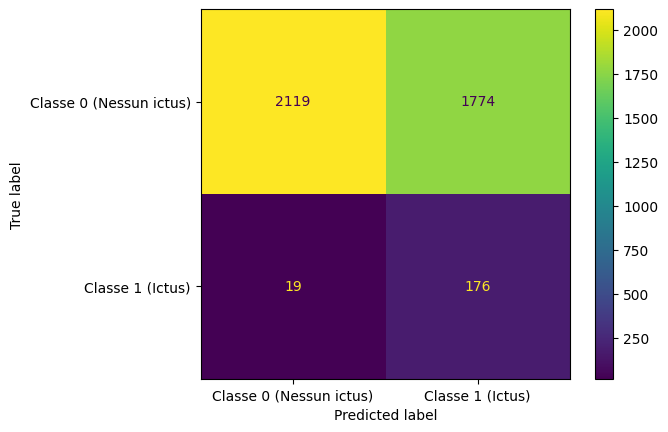

Percentuale di veri negativi: 54.43%
Percentuale di veri positivi: 90.26%
                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.99      0.54      0.70      3893
       Classe 1 (Ictus)       0.09      0.90      0.16       195

               accuracy                           0.56      4088
              macro avg       0.54      0.72      0.43      4088
           weighted avg       0.95      0.56      0.68      4088

[[2119 1774]
 [  19  176]]


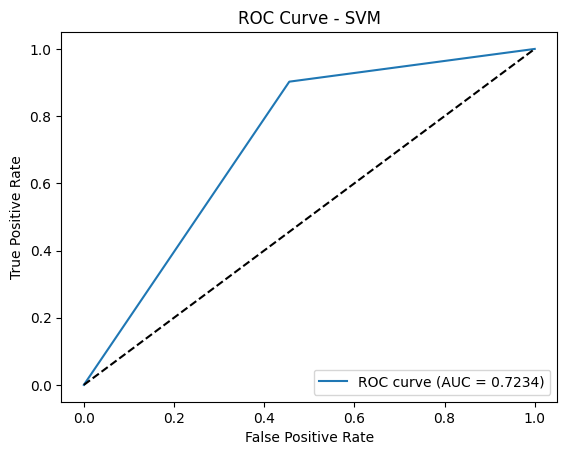

In [22]:
hard_voting_train = hard_voting_predict(models, X_preprocessed_train)

evaluate_predictions(hard_voting_train, y_train)

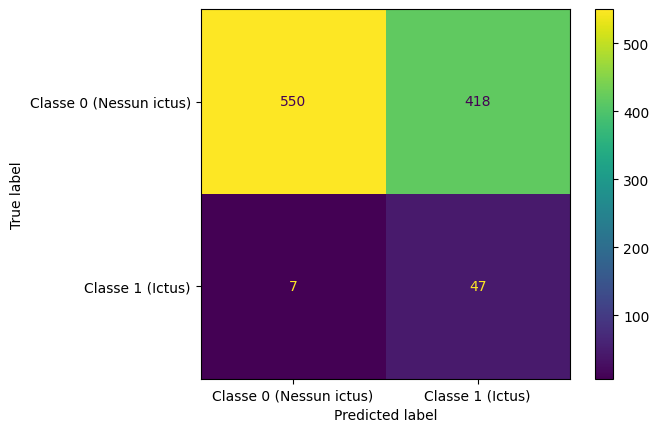

Percentuale di veri negativi: 56.82%
Percentuale di veri positivi: 87.04%
                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.99      0.57      0.72       968
       Classe 1 (Ictus)       0.10      0.87      0.18        54

               accuracy                           0.58      1022
              macro avg       0.54      0.72      0.45      1022
           weighted avg       0.94      0.58      0.69      1022

[[550 418]
 [  7  47]]


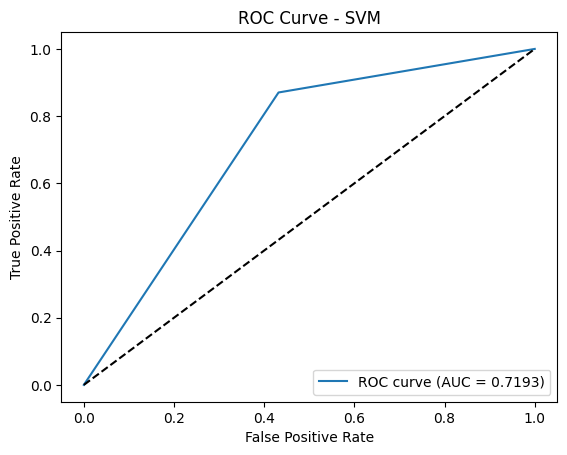

In [23]:
X_preprocessed_test = pipeline_preprocessing.transform(X_test)

hard_voting_test = hard_voting_predict(models, X_preprocessed_test)

evaluate_predictions(hard_voting_test, y_test)